In [1]:
!nvcc --version
!python -c "import torch; print('PyTorch:', torch.__version__, 'CUDA Available:', torch.cuda.is_available(), 'CUDA Version:', torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
PyTorch: 2.5.1+cu121 CUDA Available: True CUDA Version: 12.1


In [2]:
# Step 2: Uninstall Conflicting Packages
!pip uninstall -y mmcv mmcv-full mmdet torch torchvision tensorflow tensorboard -q

In [3]:
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 -f https://download.pytorch.org/whl/torch_stable.html -q
!pip install mmcv-full==1.7.1 -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.0/index.html -q
!pip install mmdet==2.28.2 -q
!pip install -U openmim -q
!mim install "mmengine>=0.7.0" -q
!pip install xmltodict -q  # For dataset conversion

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 447.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 49.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.5.0.post0 requires torch>=2.1.0, but you have torch 1.13.1+cu116 which is incompatible.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 1.13.1+cu116 which is incompatible.
torchmetrics 1.6.1 requires torch>=2.0.0, but you have torch 1.13.1+cu116 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Step 4: Clone and Install MMRotate 0.3.4
!git clone https://github.com/open-mmlab/mmrotate.git /kaggle/working/mmrotate
%cd /kaggle/working/mmrotate
# !git checkout v0.3.4  # Ensure exact version
!pip install -r requirements/build.txt -q
!pip install -v -e . -q

Cloning into '/kaggle/working/mmrotate'...
remote: Enumerating objects: 3897, done.
remote: Counting objects: 100% (1242/1242), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 3897 (delta 972), reused 866 (delta 866), pack-reused 2655 (from 2)
Receiving objects: 100% (3897/3897), 25.30 MiB | 21.01 MiB/s, done.
Resolving deltas: 100% (2395/2395), done.
/kaggle/working/mmrotate
Obtaining file:///kaggle/working/mmrotate
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 9.4 MB/s eta 0:00:00
  Running setup.py develop for mmrotate


In [5]:
# Step 5: Verify Installations
!pip list | grep -E 'torch|mmcv|mmdet|mmengine|mmrotate'

mmcv-full                          1.7.1
mmdet                              2.28.2
mmengine                           0.10.7
mmrotate                           0.3.4                /kaggle/working/mmrotate
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
torch                              1.13.1+cu116
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune                          0.5.0
torchvision                        0.14.1+cu116


In [6]:
# Step 6: Prepare Dataset (SCCOS to DOTA format)
import os
import shutil
import random
import xmltodict
import tqdm
import math

dataset_path = "/kaggle/input/sccos-dataset/"
working_dir = "/kaggle/working/sccos_dota"
train_images_dir = os.path.join(working_dir, "train/images")
train_labels_dir = os.path.join(working_dir, "train/labels")
val_images_dir = os.path.join(working_dir, "val/images")
val_labels_dir = os.path.join(working_dir, "val/labels")
test_images_dir = os.path.join(working_dir, "test/images")
test_labels_dir = os.path.join(working_dir, "test/labels")

In [7]:
# Clean and recreate directories
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
for dir_path in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir, test_images_dir, test_labels_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Source paths
train_img_dir = os.path.join(dataset_path, "train/images")
train_ann_dir = os.path.join(dataset_path, "train/annotations")
test_img_dir = os.path.join(dataset_path, "test/images")
test_ann_dir = os.path.join(dataset_path, "test/annotations")

# Get all files and split
train_files = [f for f in os.listdir(train_img_dir) if f.endswith('.png')]
test_files = [f for f in os.listdir(test_img_dir) if f.endswith('.png')]
random.seed(42)
random.shuffle(train_files)
random.shuffle(test_files)
test_size = len(test_files)
val_size = test_size // 2
val_files = test_files[:val_size]
test_files = test_files[val_size:]

# Copy files
def copy_files(file_list, src_img_dir, src_ann_dir, dst_img_dir, dst_ann_dir):
    for img_file in file_list:
        shutil.copy(os.path.join(src_img_dir, img_file), os.path.join(dst_img_dir, img_file))
        ann_file = img_file.replace('.png', '.xml')
        if os.path.exists(os.path.join(src_ann_dir, ann_file)):
            shutil.copy(os.path.join(src_ann_dir, ann_file), os.path.join(dst_ann_dir, ann_file))

copy_files(train_files, train_img_dir, train_ann_dir, train_images_dir, train_labels_dir)
copy_files(val_files, test_img_dir, test_ann_dir, val_images_dir, val_labels_dir)
copy_files(test_files, test_img_dir, test_ann_dir, test_images_dir, test_labels_dir)
print(f"Dataset split: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

# Convert XML to DOTA format
def convert_robndbox_to_corners(cx, cy, w, h, angle):
    angle = float(angle)
    cx, cy, w, h = float(cx), float(cy), float(w), float(h)
    cos_a = math.cos(angle)
    sin_a = math.sin(angle)
    dx, dy = w / 2, h / 2
    corners = [(-dx, -dy), (dx, -dy), (dx, dy), (-dx, dy)]
    rotated_corners = [(cx + x * cos_a - y * sin_a, cy + x * sin_a + y * cos_a) for x, y in corners]
    return rotated_corners

def convert_xml_to_dota(xml_path, output_label_dir):
    with open(xml_path, 'r') as f:
        xml_data = xmltodict.parse(f.read())
    objects = xml_data['annotation'].get('object', [])
    if not isinstance(objects, list):
        objects = [objects] if objects else []
    txt_lines = []
    for obj in objects:
        if obj and 'robndbox' in obj:
            robndbox = obj['robndbox']
            try:
                cx, cy, w, h, angle = robndbox['cx'], robndbox['cy'], robndbox['w'], robndbox['h'], robndbox['angle']
                (x1, y1), (x2, y2), (x3, y3), (x4, y4) = convert_robndbox_to_corners(cx, cy, w, h, angle)
                class_name = "ship"
                difficulty = 0
                txt_lines.append(f"{x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f} {x3:.2f} {y3:.2f} {x4:.2f} {y4:.2f} {class_name} {difficulty}")
            except (KeyError, ValueError) as e:
                print(f"Invalid robndbox data in {xml_path}: {e}")
                continue
    txt_filename = os.path.splitext(os.path.basename(xml_path))[0] + ".txt"
    txt_path = os.path.join(output_label_dir, txt_filename)
    if txt_lines:
        with open(txt_path, 'w') as f:
            f.write("\n".join(txt_lines))
    os.remove(xml_path)

for split, label_dir in [("train", train_labels_dir), ("val", val_labels_dir), ("test", test_labels_dir)]:
    print(f"Converting {split} set to DOTA format...")
    for xml_file in tqdm.tqdm(os.listdir(label_dir)):
        if xml_file.endswith(".xml"):
            convert_xml_to_dota(os.path.join(label_dir, xml_file), label_dir)
print("Dataset conversion to DOTA format complete.")

Dataset split: Train=3711, Val=464, Test=464
Converting train set to DOTA format...


100%|██████████| 3711/3711 [00:01<00:00, 2114.33it/s]


Converting val set to DOTA format...


100%|██████████| 464/464 [00:00<00:00, 1977.65it/s]


Converting test set to DOTA format...


100%|██████████| 464/464 [00:00<00:00, 2225.44it/s]

Dataset conversion to DOTA format complete.


In [8]:
# NEW: Fix YAPF compatibility issue
!pip install yapf==0.32.0 -q  # Pin to a version compatible with MMCV 1.7.1

# NEW: Validate training images
import os
import cv2
import mmcv

def validate_images(image_dir, label_dir):
    bad_files = []
    for img_file in os.listdir(image_dir):
        if not img_file.endswith('.png'):
            continue
        img_path = os.path.join(image_dir, img_file)
        # Check if file is empty
        if os.path.getsize(img_path) == 0:
            bad_files.append(img_file)
            print(f"Empty file detected: {img_path}")
            continue
        # Try loading with mmcv (mimics pipeline behavior)
        try:
            img = mmcv.imread(img_path)
            if img is None:
                raise ValueError("Image loaded as None")
        except Exception as e:
            bad_files.append(img_file)
            print(f"Corrupt or unreadable file: {img_path} - Error: {e}")
    
    # Remove bad files and their labels
    for bad_file in bad_files:
        img_path = os.path.join(image_dir, bad_file)
        label_file = bad_file.replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_file)
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f"Removed bad image: {img_path}")
        if os.path.exists(label_path):
            os.remove(label_path)
            print(f"Removed corresponding label: {label_path}")
    
    if bad_files:
        print(f"Found and handled {len(bad_files)} bad files.")
    else:
        print("All images validated successfully.")

# Validate training set
train_images_dir = "/kaggle/working/sccos_dota/train/images"
train_labels_dir = "/kaggle/working/sccos_dota/train/labels"
print("Validating training images...")
validate_images(train_images_dir, train_labels_dir)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 8.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


Validating training images...
Empty file detected: /kaggle/working/sccos_dota/train/images/2284.png
Removed bad image: /kaggle/working/sccos_dota/train/images/2284.png
Removed corresponding label: /kaggle/working/sccos_dota/train/labels/2284.txt
Found and handled 1 bad files.


In [9]:
# Step 7: Create Config File for RoI Transformer
config_content = """
_base_ = [
    '../_base_/datasets/dotav1.py', '../_base_/schedules/schedule_1x.py',
    '../_base_/default_runtime.py'
]

angle_version = 'le90'  # Use [-90, 90) range for oriented bounding boxes
dataset_type = 'DOTADataset'
data_root = '/kaggle/working/sccos_dota/'
classes = ('ship',)  # Single class
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version=angle_version),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='MultiScaleFlipAug', img_scale=(1024, 1024), flip=False,
         transforms=[
             dict(type='RResize'),
             dict(type='Normalize', **img_norm_cfg),
             dict(type='Pad', size_divisor=32),
             dict(type='DefaultFormatBundle'),
             dict(type='Collect', keys=['img'])
         ])
]

data = dict(
    samples_per_gpu=4,
    workers_per_gpu=2,
    train=dict(
        type=dataset_type,
        ann_file=data_root + 'train/labels/',
        img_prefix=data_root + 'train/images/',
        pipeline=train_pipeline,
        classes=classes,
        version=angle_version),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'val/labels/',
        img_prefix=data_root + 'val/images/',
        pipeline=test_pipeline,
        classes=classes,
        version=angle_version),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'test/labels/',
        img_prefix=data_root + 'test/images/',
        pipeline=test_pipeline,
        classes=classes,
        version=angle_version))

evaluation = dict(interval=1, metric='mAP')
optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11])
runner = dict(type='EpochBasedRunner', max_epochs=20)
checkpoint_config = dict(interval=1)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook')])

model = dict(
    type='RoITransformer',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RotatedRPNHead',
        in_channels=256,
        feat_channels=256,
        version=angle_version,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),
    roi_head=dict(
        type='RoITransRoIHead',
        version=angle_version,
        num_stages=2,
        stage_loss_weights=[1, 1],
        bbox_roi_extractor=[
            dict(
                type='SingleRoIExtractor',
                roi_layer=dict(
                    type='RoIAlign', output_size=7, sampling_ratio=0),
                out_channels=256,
                featmap_strides=[4, 8, 16, 32]),
            dict(
                type='RotatedSingleRoIExtractor',
                roi_layer=dict(
                    type='RoIAlignRotated',
                    out_size=7,
                    sample_num=2,
                    clockwise=True),
                out_channels=256,
                featmap_strides=[4, 8, 16, 32]),
        ],
        bbox_head=[
            dict(
                type='RotatedShared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=1,  # Single class: ship
                bbox_coder=dict(
                    type='DeltaXYWHAHBBoxCoder',
                    angle_range=angle_version,
                    norm_factor=2,
                    edge_swap=True,
                    target_means=[0.0, 0.0, 0.0, 0.0, 0.0],
                    target_stds=[0.1, 0.1, 0.2, 0.2, 1]),
                reg_class_agnostic=True,
                loss_cls=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0)),
            dict(
                type='RotatedShared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=1,  # Single class: ship
                bbox_coder=dict(
                    type='DeltaXYWHAOBBoxCoder',
                    angle_range=angle_version,
                    norm_factor=None,
                    edge_swap=True,
                    proj_xy=True,
                    target_means=[0.0, 0.0, 0.0, 0.0, 0.0],
                    target_stds=[0.05, 0.05, 0.1, 0.1, 0.5]),
                reg_class_agnostic=False,
                loss_cls=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))
        ]),
    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False),
            allowed_border=0,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=2000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=[
            dict(
                assigner=dict(
                    type='MaxIoUAssigner',
                    pos_iou_thr=0.5,
                    neg_iou_thr=0.5,
                    min_pos_iou=0.5,
                    match_low_quality=False,
                    ignore_iof_thr=-1,
                    iou_calculator=dict(type='BboxOverlaps2D')),
                sampler=dict(
                    type='RandomSampler',
                    num=512,
                    pos_fraction=0.25,
                    neg_pos_ub=-1,
                    add_gt_as_proposals=True),
                pos_weight=-1,
                debug=False),
            dict(
                assigner=dict(
                    type='MaxIoUAssigner',
                    pos_iou_thr=0.5,
                    neg_iou_thr=0.5,
                    min_pos_iou=0.5,
                    match_low_quality=False,
                    ignore_iof_thr=-1,
                    iou_calculator=dict(type='RBboxOverlaps2D')),
                sampler=dict(
                    type='RRandomSampler',
                    num=512,
                    pos_fraction=0.25,
                    neg_pos_ub=-1,
                    add_gt_as_proposals=True),
                pos_weight=-1,
                debug=False)
        ]),
    test_cfg=dict(
        rpn=dict(
            nms_pre=2000,
            max_per_img=2000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            nms_pre=2000,
            min_bbox_size=0,
            score_thr=0.05,
            nms=dict(type=angle_version, iou_thr=0.1),
            max_per_img=2000))
)
"""

config_path = "/kaggle/working/mmrotate/configs/roi_trans/roi_trans_r50_fpn_1x_sccos.py"
with open(config_path, 'w') as f:
    f.write(config_content)
print(f"RoI Transformer configuration saved to {config_path}")

RoI Transformer configuration saved to /kaggle/working/mmrotate/configs/roi_trans/roi_trans_r50_fpn_1x_sccos.py


In [10]:
# Step 8: Train the Model
%cd /kaggle/working/mmrotate
!mkdir -p /kaggle/working/runs/roi_trans_train
!python tools/train.py \
    configs/roi_trans/roi_trans_r50_fpn_1x_sccos.py \
    --work-dir /kaggle/working/runs/roi_trans_train \
    --gpus 1

print("Training completed.")

/kaggle/working/mmrotate
/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/kaggle/working/mmrotate/mmrotate/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optim

In [11]:
# Step 9: Test the Model
%cd /kaggle/working/mmrotate
!mkdir -p /kaggle/working/runs/roi_trans_test
!python tools/test.py \
    configs/roi_trans/roi_trans_r50_fpn_1x_sccos.py \
    /kaggle/working/runs/roi_trans_train/latest.pth \
    --eval mAP \
    --out /kaggle/working/runs/roi_trans_test/results.pkl \
    --show-dir /kaggle/working/runs/roi_trans_test/vis

print("Testing completed.")

/kaggle/working/mmrotate
/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/kaggle/working/mmrotate/mmrotate/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optim

In [12]:
!ls /kaggle/working/runs/roi_trans_test/vis

0005.png  0582.png  1050.png  1726.png	2267.png  2757.png  3329.png  4049.png
0014.png  0612.png  1052.png  1729.png	2272.png  2764.png  3345.png  4055.png
0018.png  0617.png  1073.png  1747.png	2277.png  2769.png  3367.png  4062.png
0042.png  0618.png  1084.png  1752.png	2278.png  2774.png  3372.png  4095.png
0046.png  0622.png  1086.png  1755.png	2279.png  2786.png  3377.png  4101.png
0051.png  0627.png  1093.png  1792.png	2282.png  2787.png  3382.png  4108.png
0052.png  0642.png  1100.png  1793.png	2283.png  2808.png  3385.png  4117.png
0058.png  0654.png  1101.png  1805.png	2286.png  2828.png  3394.png  4119.png
0106.png  0657.png  1110.png  1806.png	2305.png  2831.png  3398.png  4144.png
0118.png  0661.png  1112.png  1814.png	2308.png  2833.png  3419.png  4154.png
0128.png  0671.png  1116.png  1823.png	2310.png  2855.png  3432.png  4158.png
0134.png  0680.png  1132.png  1827.png	2324.png  2856.png  3436.png  4174.png
0160.png  0688.png  1143.png  1836.png	2329.png  2864.png  3441.

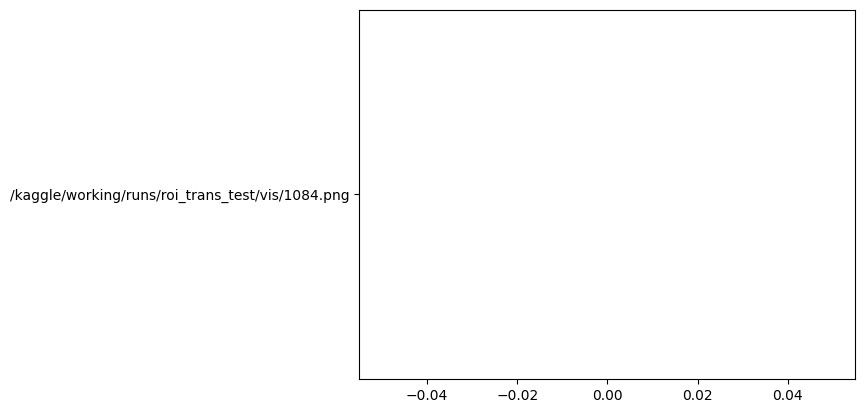

In [13]:
import matplotlib.pyplot as plt
import random

test_vis = random.choice(os.listdir("/kaggle/working/runs/roi_trans_test/vis"))

plt.plot(f"/kaggle/working/runs/roi_trans_test/vis/{test_vis}")